In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nunenuh_flickr8k_path = kagglehub.dataset_download('nunenuh/flickr8k')

print('Data source import complete.')


100%|██████████| 1.04G/1.04G [00:13<00:00, 84.8MB/s]

Extracting files...


Data source import complete.


# Section 1 : Importation des bibliothèques nécessaires
 Ce bloc importe toutes les bibliothèques pour la manipulation des données, le traitement NLP, la vision par ordinateur, et l'intégration du texte arabe.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from os import listdir
from tqdm import tqdm_notebook, tnrange
import keras
from keras_tqdm import TQDMNotebookCallback
print(keras.__version__)
from bidi import algorithm as bidialg
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Model
from PIL import Image
from bidi.algorithm import get_display
#These for NLP:
import nltk
from nltk import word_tokenize
import pyarabic.araby as ar
import string
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from pyarabic.araby import strip_harakat
from pyarabic.araby import strip_tashkeel
from pyarabic.araby import strip_diacritics
from pyarabic.araby import strip_tatweel, strip_shadda
from pyarabic.araby import normalize_ligature
import pyarabic.number
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from string import punctuation
from tensorflow.keras.layers import concatenate
from keras.models import load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import add
from keras.callbacks import ModelCheckpoint
import arabic_reshaper
from collections import Counter
import random
from numpy import argmax
import pyarabic.number

2.10.0


# Définition des chemins d'accès aux données

In [6]:
directory = f'{nunenuh_flickr8k_path}/images'
arabic_captions_path='/content/drive/MyDrive/img_cpt/Flickr8k.arabic.full.txt'
filetrain='/content/drive/MyDrive/img_cpt/trainImages.txt'
filetest='/content/drive/MyDrive/img_cpt/testImages.txt'
images_features_path='/content/drive/MyDrive/img_cpt/features_EfficientNetB0.pkl'
cleaned_captions_directory='/content/drive/MyDrive/img_cpt/clean_capt.txt'
tokenfile='/content/drive/MyDrive/img_cpt/tokenizer.pkl'

# Analyse des dimensions minimales des images
 Parcourt toutes les images dans le répertoire pour déterminer les dimensions minimales en termes de largeur et de hauteur.


In [7]:
min_height, min_width = float('inf'), float('inf')  # Initialiser les dimensions minimales à une très grande valeur
min_img_file, min_img1_file = None, None  # Variables pour stocker les chemins des images correspondantes

# Parcourir les fichiers dans le répertoire
for filename in os.listdir(directory):
    try:
        img_path = os.path.join(directory, filename)
        with Image.open(img_path) as img:  # Ouvrir l'image avec PIL
            width, height = img.size  # Obtenir la largeur et la hauteur
            # Mettre à jour les dimensions minimales
            if width < min_width:
                min_width, min_img1_file = width, img_path
            if height < min_height:
                min_height, min_img_file = height, img_path
    except Exception as e:
        print(f"Erreur lors du traitement de {filename} : {e}")

# Afficher les résultats
print(f"Largeur minimale : {min_width}, Fichier : {min_img1_file}")
print(f"Hauteur minimale : {min_height}, Fichier : {min_img_file}")

# Afficher les images correspondantes
if min_img_file:
    Image.open(min_img_file).show()
if min_img1_file:
    Image.open(min_img1_file).show()


Largeur minimale : 164, Fichier : /root/.cache/kagglehub/datasets/nunenuh/flickr8k/versions/2/images/3039209547_81cc93fbec.jpg
Hauteur minimale : 127, Fichier : /root/.cache/kagglehub/datasets/nunenuh/flickr8k/versions/2/images/456512643_0aac2fa9ce.jpg


# Chargement et traitement des légendes

*   Cette section définit une fonction pour charger les légendes à partir d'un fichier texte

*   les structure en un dictionnaire basé sur les identifiants d'image.




In [8]:
def load_captions(caption_text):
    mapping = {}
    for line in caption_text.split('\n'):
        token = line.split('\t')  # Diviser la ligne en ID d'image et légendes
        if len(token) < 2:  # Ignorer les lignes incorrectes
            continue
        image_id, image_desc = token[0].split('.')[0], '.'.join(token[1:])
        mapping.setdefault(image_id, []).append(image_desc)  # Ajouter la légende
    return mapping

# Charger et traiter les légendes
captions_path = '/content/drive/MyDrive/img_cpt/Flickr8k.arabic.full.txt'
try:
    with open(captions_path, 'r', encoding='utf-8') as f:
        captions_text = f.read()
    captions = load_captions(captions_text)
except FileNotFoundError:
    print("Fichier des légendes introuvable.")
    captions = {}


# Visualisation des images avec leurs légendes
Cette section affiche un sous-ensemble d'images et leurs légendes en arabe.

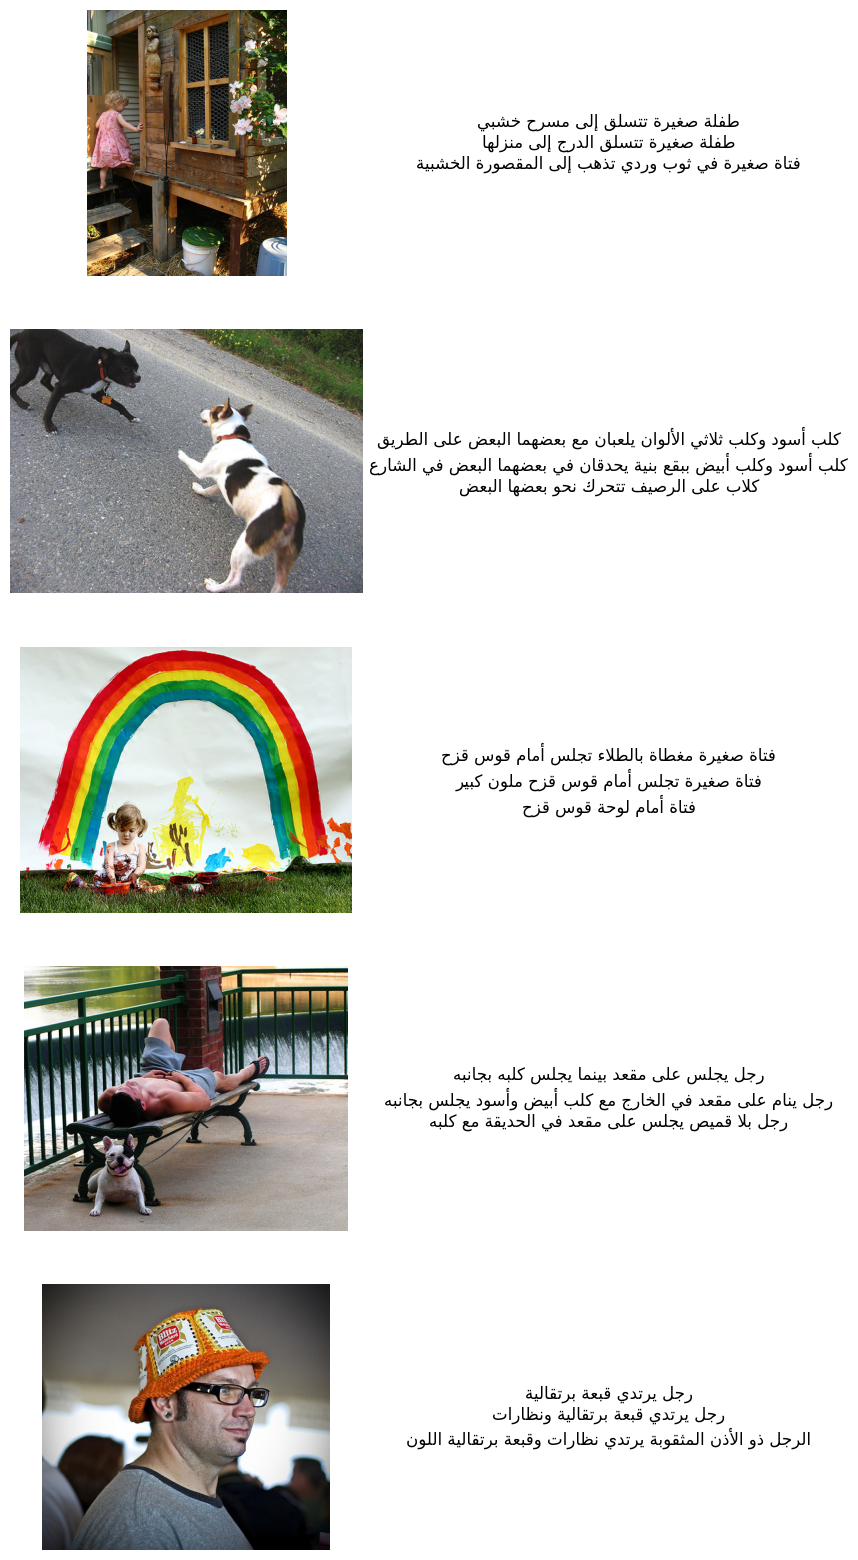

In [9]:

def visualize_images_with_captions(captions, directory, n_pics=5):
    fig = plt.figure(figsize=(10, n_pics * 4))  # Taille de la figure
    for i, (img_id, cpts) in enumerate(captions.items()):
        if i >= n_pics:  # Limiter le nombre d'images affichées
            break
        try:
            img_path = os.path.join(directory, f"{img_id}.jpg")
            img = load_img(img_path)  # Charger l'image
            caption = get_display(arabic_reshaper.reshape('\n'.join(cpts)))  # Reshaper et afficher le texte arabe
            # Afficher l'image
            ax1 = fig.add_subplot(n_pics, 2, 2 * i + 1)
            ax1.imshow(img)
            ax1.axis("off")
            # Afficher la légende
            ax2 = fig.add_subplot(n_pics, 2, 2 * i + 2)
            ax2.text(0.5, 0.5, caption, ha="center", va="center", wrap=True, fontsize=12)
            ax2.axis("off")
        except Exception as e:
            print(f"Erreur d'affichage pour l'image {img_id} : {e}")

# Visualiser un sous-ensemble d'images avec leurs légendes
subset = {k: captions[k] for k in list(captions.keys())[:10]}
visualize_images_with_captions(subset, directory)


#Chargement des légendes dans un dataframe
Cette section charge et formate les légendes dans un DataFrame pour un traitement plus avancé.


In [10]:

# Charger les légendes à partir du fichier
def load_captions_to_dataframe(arabic_captions_path):
    with open(arabic_captions_path, 'r', encoding='utf-8') as file:
        text = file.read()

    datatxt = []
    for line in text.split('\n'):
        col = line.split('\t')
        if len(col) == 1:
            continue
        w = col[0].split("#")
        datatxt.append(w + [col[1].lower()])

    # Création d'un dataframe avec les colonnes appropriées
    data = pd.DataFrame(datatxt, columns=["file", "index", "caption"])
    data = data.reindex(columns=['index', 'file', 'caption'])
    return data


# Analyse des mots dans les légendes
Cette section analyse les mots et génère des visualisations.

In [11]:
# Analyse des mots
def df_word(data):
    vocabulary = []
    for caption in data['caption']:
        vocabulary.extend(caption.split())

    print(f'Taille du vocabulaire : {len(set(vocabulary))}')

    # Compter les mots et trier
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word": list(ct.keys()), "count": list(ct.values())})
    dfword = dfword.sort_values("count", ascending=False).reset_index(drop=True)
    return dfword

# Affichage de l'histogramme des mots les plus fréquents
def plthist(dfword, topn=50, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20, 5))
    dfsub = dfword.iloc[:topn, :]
    plt.bar(dfsub.index, dfsub["count"])
    plt.yticks(fontsize=14)
    plt.xticks(dfsub.index, dfsub["word"], rotation=90, fontsize=14)
    plt.title(title, fontsize=16)
    plt.xlabel("Mots", fontsize=14)
    plt.ylabel("Fréquence", fontsize=14)
    plt.tight_layout()
    plt.show()

 * analyse et visualisation des données

Taille du vocabulaire : 11384


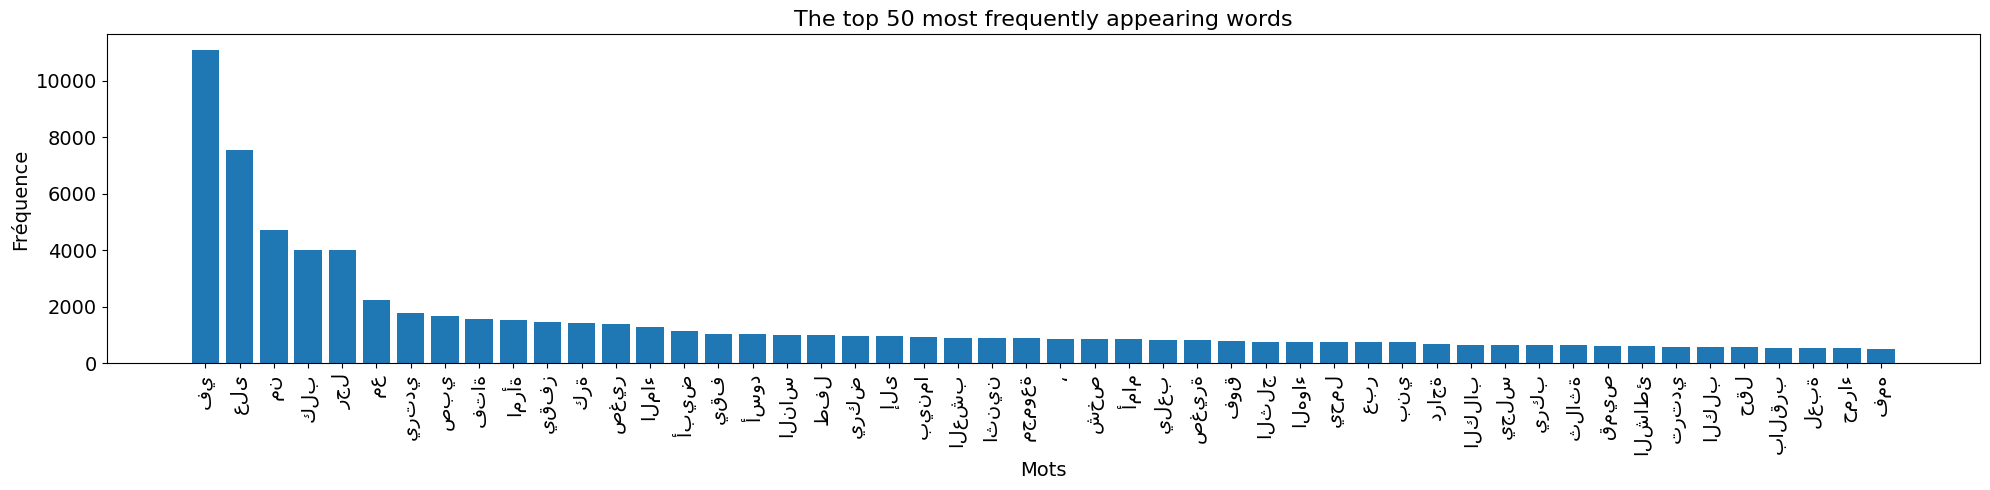

In [12]:
# Charger les données et analyser
data = load_captions_to_dataframe(arabic_captions_path)
dfword = df_word(data)

# Afficher les 50 mots les plus fréquents
plthist(dfword)


###Charger les légendes en arabe et les parser en DataFrame

In [13]:
# Charger le fichier des légendes arabes
with open(arabic_captions_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Parser les légendes en un DataFrame
datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt, columns=["file", "index", "caption"])
data = data.reindex(columns=['index', 'file', 'caption'])

### Définir les fonctions de nettoyage des légendes

In [14]:
# Définir les listes de ponctuations en arabe et en anglais
arabic_punctuations = '''`\u00f7\u00d7\u061b<>_()*&^%][\u0640\u060c/:\"\u061f.,'{}~\u00a6+|!\u2026\u201c\u2013\u0640'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

# Fonction pour supprimer les ponctuations
def remove_punctuations(text):
    """Supprimer les ponctuations."""
    return ''.join([c for c in text if c not in punctuations_list])

# Fonction pour supprimer les mots d'un seul caractère
def remove_single_character(text):
    """Supprimer les mots d'un seul caractère."""
    return ' '.join([word for word in text.split() if len(word) > 1])

# Fonction pour supprimer les préfixes définis (comme 'ال')
def remove_defining_words(text):
    """Supprimer les préfixes définis (ex : 'ال')."""
    return re.sub(r'\b\u0627\u0644(\w+)', r'\1', text)

# Fonction pour remplacer les nombres par leur équivalent textuel arabe
def remove_numeric(text):
    """Remplacer les nombres par leur équivalent textuel arabe."""
    numerals = re.findall(r'\d+', text)
    an = pyarabic.number.ArNumbers()
    text_no_numeric = text
    for numeral in numerals:
        word_form = an.int2str(numeral)
        text_no_numeric = text_no_numeric.replace(numeral, word_form)
    return text_no_numeric


# Fonction pour supprimer les diacritiques et extensions
def remove_harakat(text):
    """Supprimer les diacritiques et les extensions."""
    text_no_harakat = strip_tashkeel(text)
    text_no_diacritics = strip_diacritics(text_no_harakat)
    text_no_tatweel = strip_tatweel(text_no_diacritics)
    return re.sub(r'[a-zA-Z]+', '', text_no_tatweel)

# Fonction principale pour nettoyer le texte
def clean_text(data):
    """Appliquer toutes les étapes de nettoyage."""
    text = remove_punctuations(data)
    text = remove_numeric(text)
    text = remove_single_character(text)
    text = remove_defining_words(text)
    text = remove_harakat(text)
    return text

###Nettoyer les légendes et sauvegarder les résultats

In [15]:
# Nettoyer les captions
data['caption'] = data['caption'].apply(clean_text)

# Sauvegarder les légendes nettoyées dans un fichier
clean_captions_path = '/content/drive/MyDrive/img_cpt/clean_capt.txt'
with open(clean_captions_path, 'w', encoding='utf-8') as f:
    for i, row in data.iterrows():
        filename_without_extension = row['file'].replace('.jpg', '')
        cleaned_caption_line = f"{filename_without_extension} {row['caption']}\n"
        f.write(cleaned_caption_line)

print(f"Fichier nettoyé enregistré dans : {clean_captions_path}")


Fichier nettoyé enregistré dans : /content/drive/MyDrive/img_cpt/clean_capt.txt


### Ajouter les balises "startseq" et "endseq" aux légendes

In [16]:
# Ajouter les balises "startseq" et "endseq"
def load_clean_descriptions(captions):
    """Ajouter les balises 'startseq' et 'endseq' aux captions."""
    return captions.apply(lambda x: f"startseq {x} endseq")

data['caption'] = load_clean_descriptions(data['caption'])
data.head()


index                       file  \
0     0  1000268201_693b08cb0e.jpg   
1     1  1000268201_693b08cb0e.jpg   
2     2  1000268201_693b08cb0e.jpg   
3     0  1001773457_577c3a7d70.jpg   
4     1  1001773457_577c3a7d70.jpg   

                                             caption  
0     startseq طفلة صغيرة تتسلق إلى مسرح خشبي endseq  
1    startseq طفلة صغيرة تتسلق درج إلى منزلها endseq  
2  startseq فتاة صغيرة في ثوب وردي تذهب إلى مقصور...  
3  startseq كلب أسود وكلب ثلاثي ألوان يلعبان مع ب...  
4  startseq كلب أسود وكلب أبيض ببقع بنية يحدقان ف...

## Diviser les données en ensembles d'entraînement et de test

In [11]:
# Récupérer les noms des fichiers d'image dans le répertoire
images = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# Mélanger les noms des images aléatoirement
random.shuffle(images)

# Diviser les images en train et test (80% pour l'entraînement, 20% pour le test)
train_split_ratio = 0.8
split_index = int(len(images) * train_split_ratio)

train_images = images[:split_index]
test_images = images[split_index:]

# Chemins des fichiers de sortie
train_file = '/content/drive/MyDrive/img_cpt/trainImages.txt'
test_file = '/content/drive/MyDrive/img_cpt/testImages.txt'

# Vérifier si le répertoire de sortie existe, sinon le créer
os.makedirs(os.path.dirname(train_file), exist_ok=True)

# Sauvegarder les noms d'images dans les fichiers correspondants
with open(train_file, 'w') as f:
    for img in train_images:
        f.write(img + '\n')

with open(test_file, 'w') as f:
    for img in test_images:
        f.write(img + '\n')

print(f"Fichier d'entraînement sauvegardé dans {train_file}")
print(f"Fichier de test sauvegardé dans {test_file}")

Fichier d'entraînement sauvegardé dans /content/drive/MyDrive/img_cpt/trainImages.txt
Fichier de test sauvegardé dans /content/drive/MyDrive/img_cpt/testImages.txt


## Charger les ensembles d'images

In [12]:
# Fonction pour charger un document texte
def load_document(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Fonction pour charger un ensemble d'identifiants
def load_set(filename):
    doc = load_document(filename)
    dataset = set()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        # Supposons que les identifiants se trouvent avant le premier point '.'
        identifier = line.split('.')[0]
        dataset.add(identifier)
    return dataset

# Charger le fichier d'entraînement
filetrain = train_file  # Assurez-vous que cette variable pointe bien vers le fichier
train_set = load_set(filetrain)
print(f"Dataset d'entraînement chargé : {len(train_set)} images")


Dataset d'entraînement chargé : 6472 images


#Extraction des Caractéristiques d'Images avec EfficientNetB0

1. **Chargement du Modèle :**
   - Utilisation de **EfficientNetB0**, un modèle pré-entraîné sur ImageNet, pour l'extraction de caractéristiques.
   - La couche finale de classification est exclue (`include_top=False`) et un pooling global moyen (`pooling='avg'`) est appliqué pour générer des vecteurs de caractéristiques compacts.

2. **Prétraitement des Images :**
   - Les images du répertoire spécifié sont chargées et redimensionnées à la taille standard `(224, 224)`.
   - Les images sont transformées en tenseurs numpy et prétraitées avec `preprocess_input` pour s'aligner avec les spécifications du modèle EfficientNet.

3. **Extraction des Caractéristiques :**
   - Les vecteurs de caractéristiques sont extraits pour chaque image en passant les données prétraitées dans le modèle.
   - Les résultats sont stockés dans un dictionnaire où chaque clé est l'identifiant unique d'une image (basé sur le nom du fichier, sans extension).

4. **Gestion des Erreurs :**
   - Les erreurs potentielles lors du chargement ou de l'extraction des caractéristiques d'une image sont capturées et signalées pour éviter que le processus global ne soit interrompu.

5. **Sauvegarde des Caractéristiques :**
   - Les caractéristiques extraites sont sérialisées et sauvegardées dans un fichier `.pkl` (Pickle) dans un répertoire de sortie spécifié.
   - Le répertoire de sortie est créé s'il n'existe pas déjà.

6. **Vérification Finale :**
   - Une confirmation est affichée pour signaler que les caractéristiques ont été enregistrées avec succès.
   - En cas d'échec, un message d'erreur indique que le fichier n'a pas été sauvegardé.



In [19]:

def extract_features(directory):
    # Charger le modèle EfficientNetB0 sans la couche finale (include_top=False)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
    model = Model(inputs=base_model.inputs, outputs=base_model.output)
    model.summary()
    features = dict()
    # Parcourir chaque image dans le répertoire
    for name in os.listdir(directory):
        filename = os.path.join(directory, name)
        try:
            # Charger l'image et la prétraiter
            image = load_img(filename, target_size=(224, 224))
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)

            # Extraire les caractéristiques
            feature = model.predict(image, verbose=0)
            image_id = name.split('.')[0]  # Extraire l'identifiant de l'image
            features[image_id] = feature
            print(f"Caractéristiques extraites pour : {name}")
        except Exception as e:
            print(f"Erreur lors du traitement de l'image {name} : {str(e)}")
    return features

# Répertoire des images
images_directory =  f'{nunenuh_flickr8k_path}/images'

# Répertoire pour sauvegarder les fonctionnalités
output_directory = '/content/drive/MyDrive/img_cpt'
os.makedirs(output_directory, exist_ok=True)
output_file = os.path.join(output_directory, 'features_EfficientNetB0.pkl')

# Extraction des fonctionnalités
features = extract_features(images_directory)

# Sauvegarde des fonctionnalités
with open(output_file, 'wb') as f:
    pickle.dump(features, f)

# Vérification
if os.path.exists(output_file):
    print(f"Les fonctionnalités ont été enregistrées avec succès dans : {output_file}")
else:
    print("Erreur : le fichier n'a pas été enregistré.")


Streaming output truncated to the last 5000 lines.
Caractéristiques extraites pour : 3256274183_4eab3b2322.jpg
Caractéristiques extraites pour : 2676764246_c58205a365.jpg
Caractéristiques extraites pour : 3321956909_7b5ddf500f.jpg
Caractéristiques extraites pour : 3104400277_1524e4f758.jpg
Caractéristiques extraites pour : 2607383384_d9ce9de793.jpg
Caractéristiques extraites pour : 3388330419_85d72f7cda.jpg
Caractéristiques extraites pour : 2789937754_5d1fa62e95.jpg
Caractéristiques extraites pour : 3574627719_790325430e.jpg
Caractéristiques extraites pour : 259314892_a42b8af664.jpg
Caractéristiques extraites pour : 2260649048_ae45d17e68.jpg
Caractéristiques extraites pour : 2658360285_a0ec74ef48.jpg
Caractéristiques extraites pour : 314940358_ec1958dc1d.jpg
Caractéristiques extraites pour : 3053785363_50392f2c53.jpg
Caractéristiques extraites pour : 3488087117_2719647989.jpg
Caractéristiques extraites pour : 2873252292_ebf23f5f10.jpg
Caractéristiques extraites pour : 3275527950_41aca6

* Chargement et Filtrage des Caractéristiques d'Images

In [20]:
def load_photo_features(filename, dataset):
    all_features = pickle.load(open(filename, 'rb'))  # Charger toutes les caractéristiques enregistrées
    features = {k: all_features[k] for k in dataset}  # Filtrer uniquement les caractéristiques des images du dataset
    return features

train_features = load_photo_features(images_features_path, train_set)
train_features


{'2932498509_27cb0038ec': array([[ 0.02903555,  0.18570748, -0.13332091, ...,  0.0124908 ,
          0.0355652 , -0.09371042]], dtype=float32),
 '3454754632_977c1523be': array([[ 0.4053525 ,  0.48350444,  0.21977042, ...,  0.31173614,
         -0.15742837,  0.41143763]], dtype=float32),
 '2108799322_e25aa6e185': array([[-0.11903219, -0.15947632, -0.11422046, ...,  0.4602955 ,
         -0.14537224, -0.19131076]], dtype=float32),
 '1468429623_f001988691': array([[-0.06845187,  0.08607741, -0.0282503 , ...,  1.1685897 ,
          0.00408473, -0.00147272]], dtype=float32),
 '3349955993_a04aea97d8': array([[ 0.46843782, -0.06102883, -0.12112866, ...,  0.09390144,
          0.07752864,  0.10644585]], dtype=float32),
 '2251447809_2de73afcdf': array([[ 0.04054138,  0.01033438,  0.66430384, ...,  0.4306493 ,
         -0.12653293, -0.10311531]], dtype=float32),
 '2144846312_d4c738dc6c': array([[-0.15612236,  0.27744243,  0.03002117, ...,  0.08355477,
         -0.1728136 ,  0.6181509 ]], dtype=fl

##Chargement et nettoyage des descriptions

In [21]:
def load_clean_descriptions(filename, dataset):
    doc = load_document(filename)  # Charger le fichier contenant les descriptions nettoyées
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        # Ignorer les lignes trop courtes
        if len(tokens) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]  # ID de l'image et sa description
        # Vérifier si l'ID de l'image appartient au dataset
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'  # Ajouter les tokens spéciaux
            descriptions[image_id].append(desc)
    return descriptions

train_descriptions = load_clean_descriptions(cleaned_captions_directory, train_set)
print('Dataset %d' % len(train_descriptions))


Dataset 6472


##Préparation des données pour le tokenizer

In [22]:
def to_lines(descriptions):
    all_desc = []
    for key in descriptions:
        all_desc.extend(descriptions[key])
    return all_desc

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Taille du vocabulaire :', vocab_size)


Taille du vocabulaire : 8484


##Sauvegarde du tokenizer

In [23]:
token_directory = '/content/drive/MyDrive/img_cpt/'
filename = os.path.join(token_directory, 'tokenizer.pkl')

with open(filename, 'wb') as f:
    pickle.dump(tokenizer, f)

if tokenizer.word_index:
    print("Tokenizer created successfully.")
else:
    print("Tokenizer not created.")


Tokenizer created successfully.


###Trouver la longueur maximale d'une phrase parmi toutes les descriptions (légendes)

In [24]:
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

max_length = max_length(captions)  # Exemple d'appel
max_length


26

## Prépare les données d'entraînement pour le modèle de génération de texte.

In [25]:
def create_sequence(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)


## **Définir le modèle d'image captioning**

### Architecture du Modèle :

1. **Extracteur de Caractéristiques Visuelles :**
   - Entrée : Vecteur de caractéristiques d'image préextrait de taille `(1280,)`.
   - Traitement :
     - **Dropout (0.5)** pour éviter le surapprentissage.
     - **Dense (256, activation='relu')** pour réduire les dimensions et extraire des représentations significatives.

2. **Modèle Séquentiel pour Texte :**
   - Entrée : Séquence textuelle (par exemple, des mots ou des tokens) de longueur `max_length`.
   - Traitement :
     - **Embedding Layer** : Projette chaque mot dans un espace de dimension `256`.
     - **Dropout (0.5)** : Réduction du surapprentissage.
     - **LSTM (256)** : Capture les dépendances séquentielles pour contextualiser les séquences.

3. **Décoder les Caractéristiques Combinées :**
   - Fusion : Les sorties de l'extracteur de caractéristiques visuelles et du modèle séquentiel sont **concaténées**.
   - Traitement :
     - **Dense (256, activation='relu')** pour traiter la combinaison.
     - **Dense (vocab_size, activation='softmax')** : Génère une prédiction pour le prochain mot, où `vocab_size` représente la taille totale du vocabulaire.

4. **Compilateur du Modèle :**
   - Perte : **Categorical Crossentropy**, adaptée aux tâches de classification multi-classes.
   - Optimiseur : **Adam**, connu pour sa robustesse et son efficacité dans l'entraînement de modèles complexes.
   - Métrique : **Accuracy**, pour évaluer la performance sur les données de validation/test.


In [26]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

def define_model(vocab_size, max_length):
    # Feature Extractor
    inputs1 = Input(shape=(1280,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Sequence Model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Decoder model
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Combine [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Résumé du modèle
    print(model.summary())

    # Enregistrer et afficher le graphique du modèle
    plot_file_path = 'model.png'  # Définir le chemin pour l'image du modèle
    plot_model(model, to_file=plot_file_path, show_shapes=True)  # Enregistrer l'image
    display(Image(filename=plot_file_path))  # Afficher l'image dans le notebook

    return model


##Générateur de données pour le modèle
Cette fonction génère des données pour entraîner le modèle en traitant les légendes et les images.


In [27]:
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequence(tokenizer, max_length, desc_list, photo)
            yield [[in_img, in_seq], out_word]


## Entraînement du modèle et sauvegarde
Cette boucle effectue l'entraînement sur plusieurs époques et sauvegarde le modèle après chaque époque.


In [28]:
# Définir le répertoire pour sauvegarder le modèle
dir = "/content/drive/MyDrive/img_cpt"
if not os.path.exists(dir):
    os.makedirs(dir)

# Définir vocab_size, max_length, model, epochs et steps
vocab_size = len(tokenizer.word_index) + 1
max_length = max_length
model = define_model(vocab_size, max_length)

epochs = 15
steps = len(train_descriptions)

for i in range(epochs):
    # Créer un générateur de données
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    # Sauvegarder le modèle dans le répertoire spécifié
    model.save(os.path.join(dir, f'model_DropOut0.5_{i+1}.h5'))

print(f"Modèle sauvegardé dans {dir}")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 26, 256)      2171904     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['input_2[0][0]']                
                                                                                            

6472/6472 [==============================] - 1138s 176ms/step - loss: 2.8913 - accuracy: 0.3680
Modèle sauvegardé dans /content/drive/MyDrive/img_cpt


# **Test et Évaluation du Modèle Arabic Image Captioning**

In [7]:
def word_for_id(integer,tokenizer):
    for word , index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None
def generate_desc(model,tokenizer,photo,max_length):
    in_text='startseq'
    for i in range(max_length):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],maxlen=max_length)
        yhat=model.predict([photo,sequence],verbose=0)
        yhat=argmax(yhat)
        word=word_for_id(yhat,tokenizer)
        if word is None:
            break
        in_text+=' '+word
        if word == 'endseq':
            break
    return in_text

def extract_features_image(filename):
    # Charger le modèle EfficientNetB0 sans la couche finale
    base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
    model = Model(inputs=base_model.inputs, outputs=base_model.output)

    # Charger et redimensionner l'image
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)

    # Ajouter une dimension pour correspondre au batch size attendu
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Prétraiter l'image
    image = preprocess_input(image)

    # Extraire les caractéristiques
    feature = model.predict(image, verbose=1)
    return feature


### EXEMPLE DE TEST 1

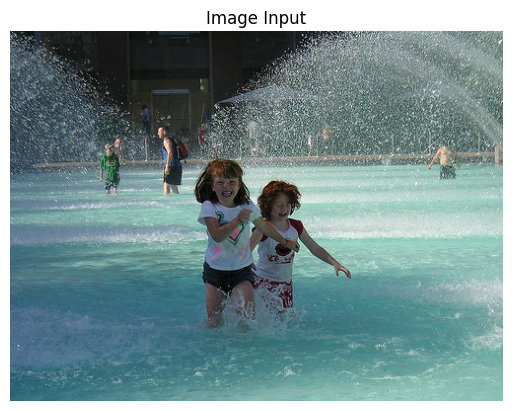

1/1 [==============================] - 2s 2s/step
Description générée : startseq صبي صغير في ثوب سباحة أزرق ويقفز في ماء endseq


In [8]:


# Charger le tokenizer
tokenizer = load(open(tokenfile, 'rb'))

# Définir la longueur maximale
max_length = 26

# Charger le modèle
model = load_model('/content/drive/MyDrive/img_cpt/model_DropOut0.5_15.h5')

# Chemin de l'image
image_path = f'{nunenuh_flickr8k_path}/images/2453971388_76616b6a82.jpg'

# Afficher l'image
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Désactiver les axes pour une meilleure visibilité
plt.title("Image Input")
plt.show()

# Charger et préparer la photo
photo = extract_features_image(image_path)

# Générer les descriptions
description = generate_desc(model, tokenizer, photo, max_length)
print("Description générée :", description)


### EXEMPLE DE TEST 2

In [21]:


# Charger le tokenizer
tokenizer = load(open(tokenfile, 'rb'))

# Définir la longueur maximale
max_length = 26

# Charger le modèle
model = load_model('/content/drive/MyDrive/img_cpt/model_DropOut0.5_15.h5')

# Chemin de l'image
image_path = f'{nunenuh_flickr8k_path}/images/381239475_044cbffa2b.jpg'

# Afficher l'image
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Désactiver les axes pour une meilleure visibilité
plt.title("Image Input")
plt.show()

# Charger et préparer la photo
photo = extract_features_image(image_path)

# Générer les descriptions
description = generate_desc(model, tokenizer, photo, max_length)
print("Description générée :", description)


1/1 [==============================] - 2s 2s/step
Description générée : startseq كلب يسبح في ماء endseq


In [16]:
def load_photo_features(filename, dataset):
    """
    Charger les caractéristiques des photos pour un ensemble donné.
    """
    all_features = pickle.load(open(filename, 'rb'))  # Charger toutes les caractéristiques
    features = {k: all_features[k] for k in dataset if k in all_features}  # Filtrer les images du dataset
    return features

# Charger les caractéristiques des images de test
test_features = load_photo_features(images_features_path, load_set(filetest))
# Charger les descriptions nettoyées pour les images de test
test_descriptions = load_clean_descriptions(cleaned_captions_directory, load_set(filetest))


### **Visualisation et Évaluation des Légendes Générées pour un Modèle Arabic Image Captioning**


1. **Objectif** :
   - Visualiser les images de test et leurs légendes générées, avec une mise en forme adaptée pour l'arabe (direction de droite à gauche).
   - Afficher les légendes générées et de référence à côté de chaque image, accompagnées des scores BLEU (1 à 4).

2. **Fonctionnalité** :
   - **Images** : Les images sont affichées dans la colonne gauche.
   - **Légendes et Scores** : Les légendes générées, les légendes de référence, et les scores BLEU (BLEU-1 à BLEU-4) sont affichés dans la colonne droite.

3. **Traitement RTL (Right-to-Left)** :
   - Les légendes en arabe sont reshaped pour respecter la direction droite-gauche à l'aide de `arabic_reshaper` et `bidi.algorithm`.

4. **Structure du Code** :
   - **Chargement des caractéristiques d'image** : Vérifie et ajuste la dimension des caractéristiques pour correspondre au modèle.
   - **Génération des légendes** : Utilise la fonction `generate_desc` pour prédire une légende en arabe pour chaque image.
   - **Calcul des Scores BLEU** :
     - BLEU-1 : Concordance unigramme.
     - BLEU-2 : Concordance bigramme.
     - BLEU-3 et BLEU-4 : Analyse des séquences plus longues.
   - **Affichage Structuré** :
     - Une sous-figure par image, avec l'image à gauche et le texte explicatif (légendes et scores) à droite.

5. **Personnalisation** :
   - **Nombre d'images** : Configurable via `num_images`.
   - **Mise en page propre** : Utilise `tight_layout` pour une présentation soignée.

6. **Résultat** :
   - **Image et Légendes** :
     - Image de test.
     - Légende générée (en arabe).
     - Légendes de référence (en arabe).
   - **Scores BLEU** :
     - BLEU-1 à BLEU-4 pour chaque image de test.


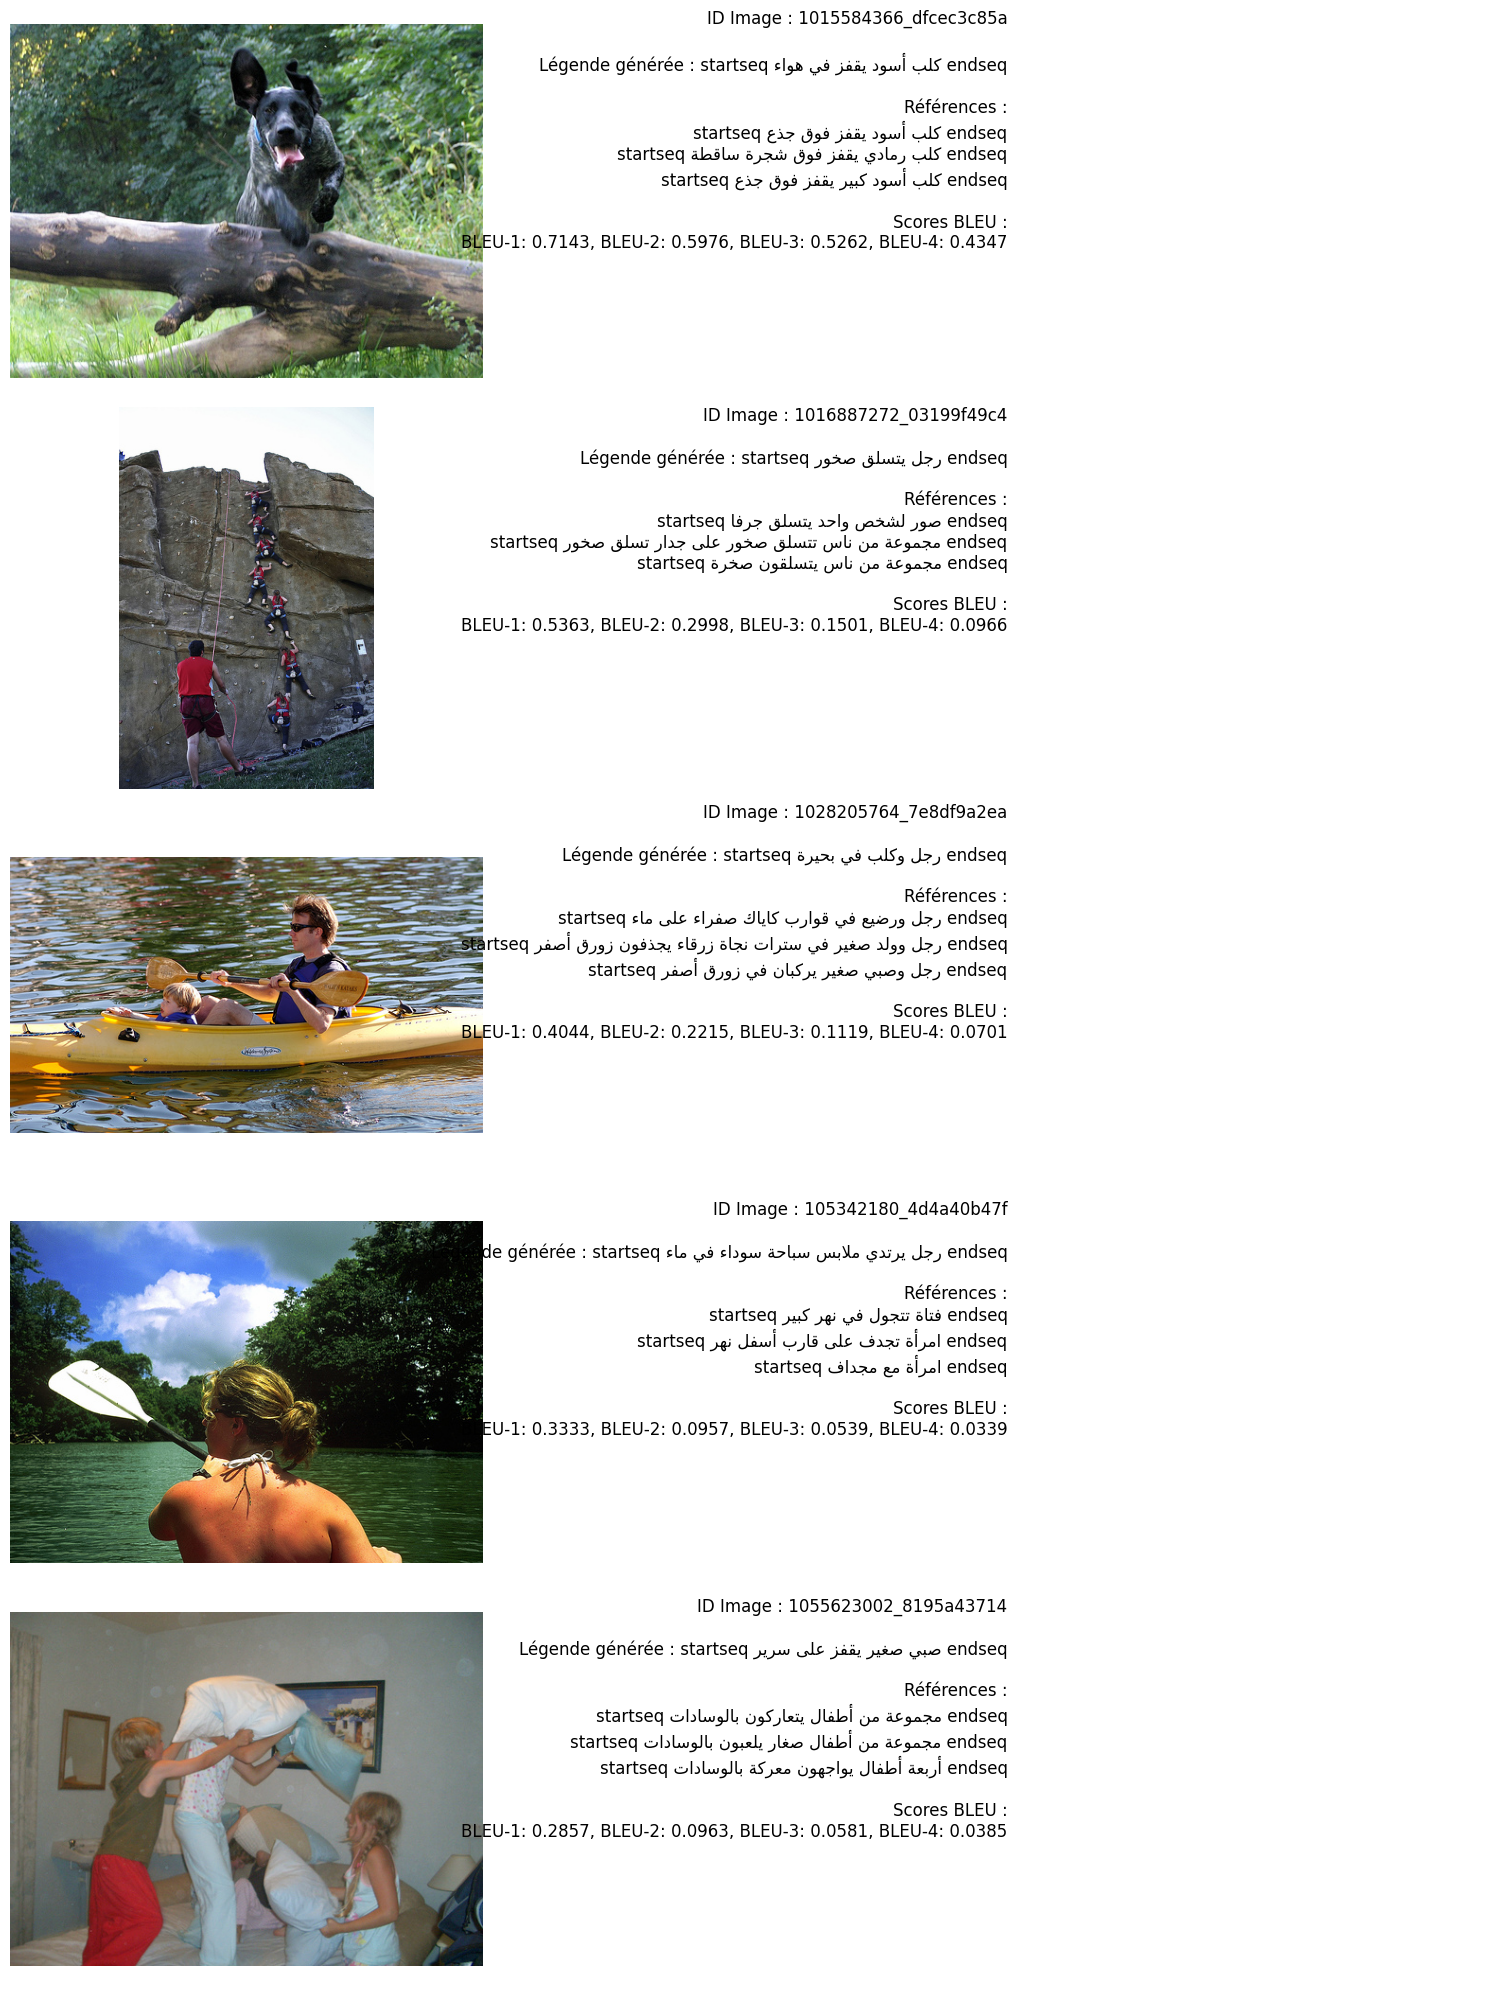

In [17]:
def visualize_test_results_rtl(model, tokenizer, test_features, test_descriptions, max_length, num_images=5):
    """
    Visualiser les résultats des images de test avec leurs légendes générées (en arabe) et les scores BLEU.
    """
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    smooth_fn = SmoothingFunction().method4

    plt.figure(figsize=(15, num_images * 4))

    for i, (key, references) in enumerate(test_descriptions.items()):
        if i >= num_images:  # Limiter le nombre d'images affichées
            break

        # Obtenir les caractéristiques de l'image et générer la légende
        photo = test_features[key][0]
        if len(photo.shape) == 1:  # Vérifier si la caractéristique est de la forme (1280,)
            photo = photo.reshape(1, -1)  # Redimensionner en (1, 1280)
        generated_caption = generate_desc(model, tokenizer, photo, max_length)

        # Reshaper et afficher la légende générée et les références en arabe
        reshaped_generated = get_display(arabic_reshaper.reshape(generated_caption))
        reshaped_references = [get_display(arabic_reshaper.reshape(ref)) for ref in references]

        # Calcul des scores BLEU
        bleu_scores = {
            "BLEU-1": sentence_bleu([ref.split() for ref in references], generated_caption.split(), weights=(1, 0, 0, 0), smoothing_function=smooth_fn),
            "BLEU-2": sentence_bleu([ref.split() for ref in references], generated_caption.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn),
            "BLEU-3": sentence_bleu([ref.split() for ref in references], generated_caption.split(), weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn),
            "BLEU-4": sentence_bleu([ref.split() for ref in references], generated_caption.split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn),
        }

        # Charger et afficher l'image
        img_path = os.path.join(directory, f"{key}.jpg")
        img = plt.imread(img_path)

        # Créer une sous-figure pour l'image et les légendes
        plt.subplot(num_images, 2, 2 * i + 1)  # Colonne gauche : image
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(num_images, 2, 2 * i + 2)  # Colonne droite : légendes et scores BLEU
        plt.axis('off')
        plt.text(
            0, 1, f"ID Image : {key}\n\n"
            f"Légende générée : {reshaped_generated}\n\n"
            f"Références :\n{chr(10).join(reshaped_references)}\n\n"
            f"Scores BLEU :\nBLEU-1: {bleu_scores['BLEU-1']:.4f}, "
            f"BLEU-2: {bleu_scores['BLEU-2']:.4f}, "
            f"BLEU-3: {bleu_scores['BLEU-3']:.4f}, "
            f"BLEU-4: {bleu_scores['BLEU-4']:.4f}",
            fontsize=12, va='top', ha='right', wrap=True
        )

    plt.tight_layout()
    plt.show()
# Visualiser quelques images de test avec légendes et scores BLEU
visualize_test_results_rtl(model, tokenizer, test_features, test_descriptions, max_length, num_images=5)


## **Evaluation BLEU Analyse globale**

In [18]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
def evaluate_bleu(model, tokenizer, test_features, test_descriptions, max_length):
    """
    Évalue le modèle avec les scores BLEU sur l'ensemble de test.
    """
    from keras.utils import pad_sequences
    bleu_scores = {"BLEU-1": [], "BLEU-2": [], "BLEU-3": [], "BLEU-4": []}
    smooth_fn = SmoothingFunction().method4

    for key, references in test_descriptions.items():
        photo = test_features[key][0]  # Obtenir les caractéristiques de l'image
        if len(photo.shape) == 1:  # Vérifier si la caractéristique est de la forme (1280,)
            photo = photo.reshape(1, -1)  # Redimensionner en (1, 1280)

        prediction = generate_desc(model, tokenizer, photo, max_length)
        prediction = prediction.split()  # Tokenize la prédiction
        references = [ref.split() for ref in references]  # Tokenize les références

        # Calcul des scores BLEU
        bleu_scores["BLEU-1"].append(sentence_bleu(references, prediction, weights=(1, 0, 0, 0), smoothing_function=smooth_fn))
        bleu_scores["BLEU-2"].append(sentence_bleu(references, prediction, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn))
        bleu_scores["BLEU-3"].append(sentence_bleu(references, prediction, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn))
        bleu_scores["BLEU-4"].append(sentence_bleu(references, prediction, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn))

    # Moyenne des scores BLEU
    avg_bleu_scores = {k: sum(v) / len(v) for k, v in bleu_scores.items()}
    return avg_bleu_scores


In [19]:
bleu_results = evaluate_bleu(model, tokenizer, test_features, test_descriptions, max_length)
print("Scores BLEU:", bleu_results)


Scores BLEU: {'BLEU-1': 0.4498177890240326, 'BLEU-2': 0.2669255976936372, 'BLEU-3': 0.17794740687724783, 'BLEU-4': 0.11869958616798872}


In [25]:
import matplotlib.pyplot as plt

def plot_bleu_scores(bleu_results):
    plt.figure(figsize=(8, 5))
    plt.bar(bleu_results.keys(), bleu_results.values(), color='skyblue')
    plt.title("Scores BLEU moyens sur l'ensemble de test", fontsize=16)
    plt.ylabel("Score BLEU", fontsize=14)
    plt.ylim(0, 1)  # Les scores BLEU sont compris entre 0 et 1
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

plot_bleu_scores(bleu_results)
